DATA643- Project 2
======
Prashanth Padebetttu, Parshu Rath, Adjare Windokun, Xingjia Wu
----------
<b> Summer 2016 <br>
Instructor: Andrew Catlin

Load Movielens Data
-------
<b> Load 100K movie data as pandas dataframe:

In [164]:
# Required Python Packages
from math import sqrt
from sklearn.metrics.pairwise import cosine_similarity
import csv
import pandas as pd
import numpy as np
from scipy import spatial

In [165]:
#Load data into a pandas dataframe
# Movielens data with 100,000 records
url = 'https://raw.githubusercontent.com/ppadebettu/CUNY/IS-607-Data-Acquisition-and-Management/IS643/Project_2/movielens.csv'
df = pd.read_csv(url, sep = "," , header = 0, na_values='NaN')


HTTPError: HTTP Error 503: backend read error

In [ ]:
#Check columns
#df.columns

<b>Some data exploration:

In [ ]:
#What are the 10 most rated movies?
most_rated = df.groupby('movietitle').size().sort_values(ascending=False)[:10]
most_rated

In [ ]:
#Which movies are highly rated?
movie_stats = df.groupby('movietitle').agg({'rating': [np.size, np.mean]})
movie_stats.head()



In [ ]:
#Sort by movie rating average
movie_stats.sort_values([('rating', 'mean')], ascending=False).head()

In [ ]:
#Movies that have been rated at least 100 times.
atleast_100 = movie_stats['rating']['size'] >= 100
movie_stats[atleast_100].sort_values([('rating', 'mean')], ascending=False)[:5]

In [ ]:
atmost_5 = movie_stats['rating']['size'] <= 5
movie_stats[atmost_5].sort_values([('rating', 'mean')], ascending=False)[:5]

<b> Load 100K movie data as Python dictionary:

In [ ]:
# Get movie titles
import urllib2
url = 'https://raw.githubusercontent.com/prcuny/DATA643/master/Project-2/'
movies={}
response = urllib2.urlopen(url + 'u.item')
for line in response:    
        (id,title)=line.split('|')[0:2]
        movies[id]=title


In [ ]:
# Load user ratings
mdict={}
response = urllib2.urlopen(url + 'u.data')
for line in response:
       (user,movieid,rating,ts)=line.split('\t')
       mdict.setdefault(user,{})
       mdict[user][movies[movieid]]=float(rating)



<b>Some data exploration:
</b><br>
Print first 2 users and ratings

In [ ]:
#Adapted from http://stackoverflow.com/questions/7971618/python-return-first-n-keyvalue-pairs-from-dict
from itertools import islice
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n ))
#take(2, mdict.iteritems())  
#Too Long output. 
#Try to output one user's ratings instead
#user '20' and ratings
#mdict['20']



<b> Generate dataframe from dictionary

In [ ]:
df_fromDict = pd.DataFrame.from_dict(mdict, orient='index')
df_fromDict.head()

### Normalization with center mean

- Normalized dataframe and fill NaN with 0

In [ ]:
df_norm1 = df_fromDict.apply(lambda x: x - x.mean(), axis =1) # row-wise operation

In [ ]:
df_norm = df_norm1.fillna(0) #fill NaN with 0
df_norm.head()

- Normalized dictionary with NaN removed

In [ ]:
dict_norm1 = df_norm1.to_dict(orient = "records") # list of dictionary

In [ ]:
dict_norm2 = {df_norm.index[i]: dict_norm1[i] for i in range(len(dict_norm1))} # dict of dict

In [ ]:
# Remove NaN 
from math import isnan
dict_norm = {}
# count = 0
for key, value in dict_norm2.iteritems():
    dict_temp = {}
    for key1, value1 in dict_norm2[key].iteritems():
        if not isnan(value1):
            dict_temp[key1] = value1
#     if count==0:
#         print len(dict_temp)
#         print key
#     count = 1
    dict_norm[key] = dict_temp

### User-User Collaborative Filtering
### UUCF using python dictionry

<b> Cosine Distance (User to User)

In [ ]:
#Function that returns a cosine-based similarity score for person1 and person2
def sim_cosine(dict, p1,p2):
#Get the list of mutually rated items, ignore items that were not rated by either person
 si = {}
 p1set = []
 p2set = []
 for item in dict[p1]:
       if (item in dict[p2]) and not(np.isnan(dict[p2][item])) and not(np.isnan(dict[p1][item])) :
          si[item] = 1
#If they have no rating in common, return 0
 if len(si) == 0: 
  return 0
 p1set = [dict[p1][item] for item in si.keys()]
 p2set = [dict[p2][item] for item in si.keys()]
 return (1 - spatial.distance.cosine(p1set, p2set))


In [ ]:
# Test the Cosine-based similarity function
round(sim_cosine(mdict,'2','30'), 4) # With orginal data

In [ ]:
round(sim_cosine(dict_norm,'2','30'), 4) # With normalized data

Cosine based similarities should, in principle, be similar in nature for both the normalized and non-normalized data. In other words, if the similarity is very high for un normalized data, it should bbe close to 1 in the normalized data. However, we observe widely different outputs from our functions. This may need further investigation.

<b> UUCF (python dictionary) Recommendations using cosine distance weighting: 

In [ ]:
#Function that returns 'n' recommendations for a person by using a weighted average of every other user's rankings
#Code adapted from https://github.com/arthur-e/Programming-Collective-Intelligence/blob/master/chapter2/recommendations.py
#Additional changes were added to exclude movies that were not rated or that have zero ratings

def getRecommendations(n, dict,person,similarity=sim_cosine):
 totals = {}
 simSums = {}

 for other in dict:
  #don't compare me to myself
  if other == person:
   continue
  sim = similarity(dict,person,other)
  #ignore scores of zero or lower
  if sim <= 0: 
   continue
  for item in dict[other]:
   #only score movies I haven't rated yet
   if (item not in dict[person]) or (dict[person][item] == 0) or (np.isnan(dict[person][item])) :
    #Similarity * score
    totals.setdefault(item,0)
    totals[item] += not(np.isnan(dict[other][item] * sim))
    #Sum of similarities
    simSums.setdefault(item,0)
    simSums[item] += sim

    #Create the normalized list
 rankings = [(total/simSums[item],item) for item,total in totals.items()]

 #Return the sorted list
 rankings.sort()
 rankings.reverse()
 return rankings[0:n]


<b> Get top 10 recommendations for user '20' using User-User CF

In [ ]:
#Test getRecommendations function
getRecommendations(10, mdict,'20',similarity=sim_cosine) # with original data

### UU-CF using pandas dataframe

In [ ]:
# function takes in a data frame, what you want to predict pred_id, 
#the type of collaboration, the similarity you want
# to use, and the number of responses you want to get back
## Code adapted from https://blog.liip.ch/archive/2016/06/16/recommender-system-slack-pandas-flask.html

def predict_p(dframe, pred_id, kind = 'user', similarity = cosine_similarity, n = 10):
    d = dframe.fillna(0)
    if kind == 'user':
        dists = similarity(d)
        dists_named = pd.DataFrame(dists, columns = d.index)
        dists_named.index = dists_named.columns
        
    elif kind == 'item':
        d = d.T
        dists = similarity(d)
        dists_named = pd.DataFrame(dists, columns = d.index)
        dists_named.index = dists_named.columns

    p = dists_named[pred_id].sort_values(ascending = False)
    mask = p.index.isin([pred_id])
    p = p[~mask]
    return p[:n]   

In [ ]:
df.head()

In [ ]:
# convert to wide format for analysis
d = df.pivot_table(index = 'userid', columns = 'movietitle', values = 'rating')
del d.index.name

# normalized dataframe
d_norm1 = d.apply(lambda x: x - x.mean(), axis =1) # row-wise operation
d_norm = d_norm1.fillna(0)

# original dataframe
#d = d.fillna(0)
d.head()

In [ ]:
d_norm.head()

<b> User-User Collaborative Filtering using cosine distance

<b>Predictions based on user-user cosine distance

In [ ]:
# Predict based on user/user
## At present this gives the closest users
predict_p(d, pred_id = 290, kind = 'user') # With original data

In [166]:
predict_p(d_norm, pred_id = 290, kind = 'user') # With normalized data

70     0.323139
275    0.279290
746    0.233377
536    0.233276
901    0.231759
638    0.231161
545    0.219109
896    0.218910
807    0.216560
56     0.215462
Name: 290, dtype: float64

<b> UU-CF (pandas) Recommendations

In [167]:
# Recommend items based on User similarity
def get_recommendations_user(dframe, pred_id, similarity = cosine_similarity, n = 10):
    d = dframe.fillna(0)
    t = d.ix[predict_p(d, pred_id = pred_id, n = n).index]
    #t.ix[:,:10]
    p = d.ix[pred_id].values != 0



    r = t.T.ix[~p].T
    # Delete those columns that all contain all 0, meaning that they have not been rated
    r = r.loc[:, (r != 0).any(axis=0)]
    # Have to rename the columns as we keep on getting an error
    cols = r.columns
    r.columns =  range(1, 1+ r.shape[1])
    # Calculate the mean ratings for the movies
    ratings = r.sum(axis = 0)/r.astype(bool).sum(axis= 0)
    ratings.index = cols
    return ratings.sort_values(axis = 0, ascending = False, 
                inplace = False, na_position = 'last')[:n]
    

<b> Get top 10 recommendations (UUCF/pandas)

In [168]:
#Unnormalized data
get_recommendations_user(d, pred_id = 290, similarity = cosine_similarity, n = 10) # With original data

movietitle
Enchanted April (1991)          5.0
Ran (1985)                      5.0
Perfect World, A (1993)         5.0
Persuasion (1995)               5.0
Little Princess, A (1995)       5.0
My Man Godfrey (1936)           5.0
Shadowlands (1993)              5.0
Sense and Sensibility (1995)    5.0
Army of Darkness (1993)         5.0
That Thing You Do! (1996)       5.0
dtype: float64

In [169]:
# Check the results
cut = [254, 738,881, 42,545,804,650,275,815,536]
d.loc[cut,'Enchanted April (1991)']


254    NaN
738    NaN
881    NaN
42     NaN
545    NaN
804    NaN
650    NaN
275    NaN
815    NaN
536    5.0
Name: Enchanted April (1991), dtype: float64

<b> Problem with sparse data</b><br>

Some of the movies are rated by only one user. If this user rates the movie 5 stars, then other users are recommended based on the ratings of this single rating causing the predicted rating to be very high. This can be fixed by limiting the input datasets to movies with a mainimum number of ratings (<i>e.g.</i> 20.


In [170]:
get_recommendations_user(d_norm, pred_id = 29, similarity = cosine_similarity, n = 10) # With normalized data

movietitle
Raise the Red Lantern (1991)       2.612903
As Good As It Gets (1997)          1.640000
Good Will Hunting (1997)           1.620533
Titanic (1997)                     1.386113
Get on the Bus (1996)              1.171875
Empire Strikes Back, The (1980)    1.171875
Raiders of the Lost Ark (1981)     1.171875
Hard Eight (1996)                  1.171875
Star Wars (1977)                   1.171875
Clerks (1994)                      1.171875
dtype: float64

In [171]:
r = pd.DataFrame(get_recommendations_user(d_norm, pred_id = 290, similarity = cosine_similarity, n = 10))
# With normalized data
mean_ratings = d[d.index ==290].mean(axis = 1)

r + float(mean_ratings)
r.head()

,0
movietitle,
Cop Land (1997),2.019337
Citizen Kane (1941),2.019337
Fried Green Tomatoes (1991),2.019337
"Philadelphia Story, The (1940)",2.019337
Devil in a Blue Dress (1995),2.019337


In [172]:

mean_ratings = d[r.index.values].apply(lambda x: x.mean(), axis =0)
mean_ratings.head()

movietitle
Cop Land (1997)                   3.377143
Citizen Kane (1941)               4.292929
Fried Green Tomatoes (1991)       3.764706
Philadelphia Story, The (1940)    4.115385
Devil in a Blue Dress (1995)      3.385965
dtype: float64

### Item-Item Collaborative Filtering
### II-CF using python dictionry

<b> Transpose the user-item matrix to item-user matrix

In [173]:
#Flip items and users
def item_user_switch(df):
    results={}
    for uid in df:
        for movie in df[uid]:
            results.setdefault(movie, {})
            #Flip movie & user
            results[movie][uid]=df[uid][movie]
    return results
##code adapted from http://aimotion.blogspot.com/2009/11/collaborative-filtering-implementation.html

In [174]:
#Transpose user:item to item:user dictionary
mdict_rev = item_user_switch(mdict)

In [175]:
#Check the data
x = mdict_rev["Young Poisoner's Handbook, The (1995)"]
y = mdict_rev["Window to Paris (1994)"]
print "\"Young Poisoner\'s Handbook, The (1995)\": \n %s" % x
print "\n \"Window to Paris (1994\": \n %s" % y


"Young Poisoner's Handbook, The (1995)": 
 {'590': 4.0, '592': 4.0, '595': 4.0, '456': 3.0, '634': 4.0, '276': 4.0, '486': 3.0, '279': 1.0, '490': 4.0, '118': 5.0, '857': 3.0, '21': 2.0, '49': 5.0, '871': 3.0, '181': 1.0, '342': 5.0, '420': 4.0, '936': 5.0, '473': 3.0, '582': 4.0, '7': 3.0, '773': 4.0, '758': 5.0, '617': 1.0, '76': 2.0, '246': 4.0, '387': 4.0, '90': 3.0, '655': 4.0, '868': 3.0, '13': 1.0, '59': 3.0, '861': 4.0, '865': 5.0, '50': 4.0, '537': 1.0, '518': 3.0, '828': 2.0, '294': 3.0, '372': 5.0, '430': 2.0}

 "Window to Paris (1994": 
 {'279': 4.0}


In [176]:
#Check cosine distance
sim_cosine(mdict_rev, "Young Poisoner's Handbook, The (1995)", 'Window to Paris (1994)')

1.0

In [177]:
#Get top n (=5) similar movies for a selected movie
def topSim(itemdict, movie, n=5, similarity=sim_cosine):
    scores = [(similarity(itemdict, movie, movie2), movie2) 
              for movie2 in itemdict if movie2!=movie]
    scores.sort()
    scores.reverse()
    return scores[0:n]

In [178]:
topSim(mdict_rev, 'Window to Paris (1994)', 10)
#Note that all top similar items have same cosine distance (=1).

[(1.0, "Young Poisoner's Handbook, The (1995)"),
 (1.0, 'Young Frankenstein (1974)'),
 (1.0, 'Wrong Trousers, The (1993)'),
 (1.0, 'Wizard of Oz, The (1939)'),
 (1.0, 'Winnie the Pooh and the Blustery Day (1968)'),
 (1.0, 'Willy Wonka and the Chocolate Factory (1971)'),
 (1.0, "William Shakespeare's Romeo and Juliet (1996)"),
 (1.0, 'Wild Bill (1995)'),
 (1.0, 'While You Were Sleeping (1995)'),
 (1.0, 'When We Were Kings (1996)')]

<b> Score for the top similar item: </b><br>
Although the top items predicted have score 1 each (based on cosine similarity), a detailed look of the data revealed that the predicted movied are mostly rated by only one user with a very high rating. 

In [179]:
predict_p(d, pred_id = 'Window to Paris (1994)', kind = 'item')

movietitle
Farmer & Chase (1995)          1.000000
Modern Affair, A (1995)        1.000000
Mostro, Il (1994)              1.000000
Girl in the Cadillac (1995)    1.000000
Tough and Deadly (1995)        0.980581
Open Season (1996)             0.970143
S.F.W. (1994)                  0.894427
Shooter, The (1995)            0.784465
Phat Beach (1996)              0.750000
Fausto (1993)                  0.742781
Name: Window to Paris (1994), dtype: float64

In [180]:
#Get top n (=5) recommendations for a user

def getRecommendedItems(itemUser, user, n=5, simfunc=sim_cosine):
    #switch to item-user dictionary
    userItem = item_user_switch(itemUser)
    #get movies and ratings for the user
    userRatings = userItem[user]
    scores = {}
    totalSim = {}

    #loop over items rated by this user
    for (item, rating) in userRatings.items():

        #Select top 5 movies similar to the current movie
        for (similarity, item2) in topSim(itemUser, item, n=5, similarity=simfunc):

            #Ignore movies already rated by the user
            if item2 in userRatings:
                continue
            #Get weighted scores (rating * similarity)and their sums 
            scores.setdefault(item2,0)
            scores[item2] += similarity * rating
            #Sum of all the similarities
            totalSim.setdefault(item2,0)
            totalSim[item2]+=similarity

    #Get average score (weighted similarity/total similarity)
    rankings = [(round(score/totalSim[item], 2),item) 
                for item,score in scores.items()]

    #Return the rankings (descending)
    rankings.sort(reverse=True)
    #rankings.reverse()
    return rankings[0:n]

In [181]:
#Get top n (=5) recommended items for a user
##Takes time.....have patience
getRecommendedItems(mdict_rev, '10', 10)

[(5.0, 'Wild America (1997)'),
 (5.0, 'When the Cats Away (Chacun cherche son chat) (1996)'),
 (5.0, 'What Happened Was... (1994)'),
 (5.0, 'Washington Square (1997)'),
 (5.0, 'Walkabout (1971)'),
 (5.0, 'Virtuosity (1995)'),
 (5.0, 'Underneath, The (1995)'),
 (5.0, 'Telling Lies in America (1997)'),
 (5.0, 'Sphere (1998)'),
 (5.0, 'Speed 2: Cruise Control (1997)')]

### II-CF using pandas dataframe Un Normalized Data

In [182]:
# Predict based on item/item
predict_p(d, pred_id = 'Window to Paris (1994)', kind = 'item')

movietitle
Farmer & Chase (1995)          1.000000
Modern Affair, A (1995)        1.000000
Mostro, Il (1994)              1.000000
Girl in the Cadillac (1995)    1.000000
Tough and Deadly (1995)        0.980581
Open Season (1996)             0.970143
S.F.W. (1994)                  0.894427
Shooter, The (1995)            0.784465
Phat Beach (1996)              0.750000
Fausto (1993)                  0.742781
Name: Window to Paris (1994), dtype: float64

<b> Explaining the score: </b><br>
As discussed above, the score 1 for the predicted movies are primarily due to the movie being rated by only oone user with a very high rating.

### II-CF (pandas) Recommendations Normalized Data

In [183]:
predict_p(d_norm, pred_id = "Amadeus (1984)", kind = 'item')

movietitle
Schindler's List (1993)                   0.398994
Casablanca (1942)                         0.344384
To Kill a Mockingbird (1962)              0.331411
Citizen Kane (1941)                       0.328816
Shawshank Redemption, The (1994)          0.326825
One Flew Over the Cuckoo's Nest (1975)    0.320654
Godfather, The (1972)                     0.309454
Henry V (1989)                            0.296642
Silence of the Lambs, The (1991)          0.287307
Star Wars (1977)                          0.280790
Name: Amadeus (1984), dtype: float64

## Content Based Recommendations using Attributes of Movies

In [184]:
m = range(13, df.shape[1])
m.append(9)
temp = df.ix[:,m]
d_movies= temp.groupby('movietitle').mean()
del d_movies.index.name
d_movies.head()

,unknown,action,adventure,animation,childrens,comedy,crime,documentary,drama,fantasy,filmnoir,horror,musical,mystery,romance,scifi,thriller,war,western
'Til There Was You (1997),0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1-900 (1994),0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
101 Dalmatians (1996),0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
12 Angry Men (1957),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
187 (1997),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [185]:
#predict_p(d_movies, pred_id = "Amadeus (1984)", kind = 'user')
predict_p(d_movies, pred_id = '12 Angry Men (1957)', kind = 'user', n = 10)

#dists = cosine_similarity(d_movies)
#dists_named = pd.DataFrame(dists, columns = d_movies.index)
#dists_named.index = dists_named.columns

#p = dists_named[pred_id].sort_values(ascending = False)
#mask = p.index.isin([pred_id])
#p = p[~mask]
#p[:n]   

Ghosts of Mississippi (1996)           1.0
Mr. Holland's Opus (1995)              1.0
Crows and Sparrows (1949)              1.0
Crucible, The (1996)                   1.0
Cry, the Beloved Country (1995)        1.0
Mondo (1996)                           1.0
Moll Flanders (1996)                   1.0
Small Faces (1995)                     1.0
Bitter Sugar (Azucar Amargo) (1996)    1.0
Cure, The (1995)                       1.0
Name: 12 Angry Men (1957), dtype: float64

### Recommender Evaluation

<b>Split the dataset into training and testing sets

In [186]:
from sklearn import cross_validation as cv
df1 = df[["userid", "itemid", "rating"]]
df1.columns = ["userid", "itemid", "rating"]
train_data, test_data = cv.train_test_split(df1, test_size=0.25)

In [187]:
# Check number if users in both training and test datasets
print train_data.userid.unique().shape[0], test_data.userid.unique().shape[0]

943 942


In [188]:
#Some of the code was adapated from 
#http://online.cambridgecoding.com/notebooks/eWReNYcAfB/implementing-your-own-recommender-systems-in-python-2
n_users = df1.userid.unique().shape[0]
n_items = df1.itemid.unique().shape[0]
print 'Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_items)  

Number of users = 943 | Number of movies = 1682


In [189]:
#Create two user-item matrices, one for training and another for testing
train_data_matrix = np.zeros((n_users, n_items))
for line in train_data.itertuples():
    train_data_matrix[line[1]-1, line[2]-1] = line[3]  

test_data_matrix = np.zeros((n_users, n_items))
for line in test_data.itertuples():
    test_data_matrix[line[1]-1, line[2]-1] = line[3]

In [190]:
test_data_matrix.shape

(943L, 1682L)

In [191]:
#Calculate the cosine similarity. Note, the output will range from 0 to 1 since the ratings are all positive
from sklearn.metrics.pairwise import pairwise_distances
user_similarity = pairwise_distances(train_data_matrix, metric='cosine')
item_similarity = pairwise_distances(train_data_matrix.T, metric='cosine')

In [192]:
# Prediction function for user based CF and item based CF 
def predict(ratings, similarity, type='user'):
    if type == 'user':
        #mean_user_rating = ratings.mean(axis=1), Added code to ignore zeroes while calculating mean user rating
        mean_user_rating = np.apply_along_axis(lambda v: np.mean(v[np.nonzero(v)]), 1, ratings)
        mean_user_rating[np.isnan(mean_user_rating)]=0.
        #You use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis]) 
        pred = mean_user_rating[:, np.newaxis] + (similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T)
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])     
    return pred

In [193]:
# Make prediction based on training dataset
item_prediction = predict(train_data_matrix, item_similarity, type='item')
user_prediction = predict(train_data_matrix, user_similarity, type='user')

In [194]:
user_prediction

array([[ 1.37251406,  0.43569195,  0.34733291, ...,  0.13518439,
         0.13509199,  0.13502404],
       [ 1.49709202,  0.52721524,  0.40240305, ...,  0.15827081,
         0.1597909 ,  0.15992226],
       [ 0.62241511, -0.38831349, -0.50413731, ..., -0.75470566,
        -0.75288359, -0.75281333],
       ..., 
       [ 1.77991532,  0.86983542,  0.7515377 , ...,  0.51907743,
         0.51995136,  0.52000039],
       [ 2.028882  ,  1.04658371,  0.95379891, ...,  0.71056605,
         0.71146408,  0.71179768],
       [ 1.00419442,  0.04209865, -0.0312453 , ..., -0.2440051 ,
        -0.2440874 , -0.24400363]])

<b>Evaluation

In [195]:
#Evaluate accuracy of predicted ratings using Root Mean Squared Error (RMSE).
from sklearn.metrics import mean_squared_error
from math import sqrt
def rmse(prediction, actual):
    prediction = prediction[actual.nonzero()].flatten() 
    actual = actual[actual.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, actual))

In [196]:
print 'User-based CF RMSE: ' + str(rmse(user_prediction, test_data_matrix))
print 'Item-based CF RMSE: ' + str(rmse(item_prediction, test_data_matrix))

User-based CF RMSE: 3.2986816174
Item-based CF RMSE: 3.45280417479


<b>Accuracy Metrics

In [197]:
#Accuracy Scores for the model
pred_values = user_prediction[test_data_matrix.nonzero()].flatten()
actual_values = test_data_matrix[test_data_matrix.nonzero()].flatten()
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print accuracy_score(np.array(actual_values), np.around(np.array(pred_values)))

0.01108


In [198]:
#Confuction matrix
print confusion_matrix(np.array(actual_values), np.around(np.array(pred_values)))

[[   0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0]
 [ 197  255  880  233   20    0    0    0]
 [  25  327 1825  557   43    1    0    0]
 [  19  379 4341 1939  120    1    0    0]
 [   4  189 4266 3745  317    5    0    0]
 [   4   63 1680 3119  435   11    0    0]]


In [199]:
#Classification report
print(classification_report(np.array(actual_values), np.around(np.array(pred_values))))

             precision    recall  f1-score   support

       -2.0       0.00      0.00      0.00         0
       -1.0       0.00      0.00      0.00         0
        0.0       0.00      0.00      0.00         0
        1.0       0.02      0.15      0.04      1585
        2.0       0.05      0.02      0.02      2778
        3.0       0.06      0.00      0.00      6799
        4.0       0.00      0.00      0.00      8526
        5.0       0.00      0.00      0.00      5312

avg / total       0.02      0.01      0.01     25000



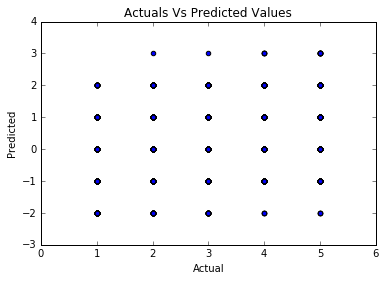

In [200]:
#Plot ground truth values Vs predicted values
%matplotlib inline
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
plt.scatter(actual_values, np.around(pred_values))
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.title('Actuals Vs Predicted Values')
plt.show()